In [7]:
#Yu Yamaoka
#crop段階でフォルダPathの指定が関数内部で行ってしまっている点に注意．

#Parameter Define
model_type = 'cyto'#https://github.com/MouseLand/cellpose/blob/main/cellpose/models.py#L19~L20
chan = [0,0]#チャンネル https://github.com/MouseLand/cellpose/blob/main/cellpose/models.py#L209

In [26]:
#Function Define
from cellpose import models, io
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
def img_to_cellpose(img_path, model_type= 'cyto', chan=[0,0], min_size=40, gpu_enabled = False, model_path = ""):
    """
    Input:
        img_path : (string) Image file PATH
    Return:
        mask : [width, height]
    Args:
        model_type : https://github.com/MouseLand/cellpose/blob/main/cellpose/models.py#L19~L20
        chan : https://github.com/MouseLand/cellpose/blob/main/cellpose/models.py#L209
        min_size : https://github.com/MouseLand/cellpose/blob/main/cellpose/models.py#L175
        gpu_enabled : Are u install cuda?
        model_path : FineTuning model Path
    """
    assert os.path.exists(img_path), ("image path is NOT exist")
    img = io.imread(img_path)
    
    # declare model
    if model_path != "":
        assert os.path.exists(model_path), ("model path is NOT exist")
        model = models.CellposeModel(gpu=gpu_enabled, pretrained_model=model_path)
        mask, _, _ = model.eval(img, diameter=None, channels=chan, min_size=min_size)
    else:
        model = models.Cellpose(gpu=gpu_enabled, model_type=model_type)
        mask, flows, styles, diams = model.eval(img, diameter=None, channels=chan, min_size=min_size)

    # save results so you can load in gui
    #io.masks_flows_to_seg(img, masks, flows, diams, img_path, chan)

    #save results as png
    #plt.imsave(img_path.replace(".png","CellposeMask.png"),masks)

    return mask

#mask画像をMaskRCNNが読み込めるデータセットにする。
def obj_detection(mask, class_id:int):
    """
    Input:
        mask : [width, height](ndarray), image data
        class_id : int , class id(ex : 1day -> 1)
    Return:
        mask : [width(int), height(int), object num(int)]
        cls_idxs : [nobject num(int)]
    """
    data = mask
    labels = []
    for label in np.unique(data):
        #: ラベルID==0は背景
        if label == 0:
            continue
        else:
            labels.append(label)

    if len(labels) == 0:
        #: 対象オブジェクトがない場合はNone
        return None, None
    else:
        mask = np.zeros((mask.shape)+(len(labels),), dtype=np.uint8)
        for n, label in enumerate(labels):
            mask[:, :, n] = np.uint8(data == label)
        cls_idxs = np.ones([mask.shape[-1]], dtype=np.int32) * class_id

        return mask, cls_idxs

def mask_to_patch(masks, img_path, mask_path, size=64):
    """
    Input:
        masks : [n(objnum), width, height], n is object num.
        img_path : original image path
        mask_path : original image path of annotation mask
    Return:
        crop_imgs :  [n(objnum), width, height, color]
        crop_masks : [n(objnum), width, height, color]
        positions : [n, 4] 切り取った画像の座標[n, (height_min, height_max, width_min, width_max)]
    """
    #各mask-objのBBOXの重心点を求めて切り抜き
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    width, height, _ = img.shape
    crop_imgs = np.zeros((size, size, 3)+(len(masks),), dtype=np.uint8)
    crop_masks = np.zeros((size, size, 3)+(len(masks),), dtype=np.uint8)
    positions = np.zeros((len(masks), 4), dtype=np.string_)
    
    #1オブジェクトごとにcropをする
    for i in range(len(masks)):
        #重心計算
        mu = cv2.moments(masks[i], False)
        g_height, g_width = int(mu["m10"]/mu["m00"]) , int(mu["m01"]/mu["m00"])
        
        height_min = g_height - size//2
        height_max = g_height + size//2
        width_min = g_width - size//2
        width_max = g_width + size//2
        
        #壁際の例外処理
        if height_min<0:#配列外アクセスを防ぐ
            height_min = 0
            height_max= (size//2) * 2
        elif height_max>height:#配列外アクセスを防ぐ
            height_min = height - ((size//2)  * 2 + 1)
            height_max = height - 1
    
        #壁際の例外処理
        if width_min<0:#配列外アクセスを防ぐ
            width_min = 0
            width_max= (size//2) * 2
        elif width_max>width:#配列外アクセスを防ぐ
            width_min = width - ((size//2)  * 2 + 1)
            width_max = width - 1
        
        crop_imgs[:, :, :, i] = img[width_min:width_max, height_min:height_max]
        crop_masks[:, :, :, i] = mask[width_min:width_max, height_min:height_max]
        positions[i] = [height_min, height_max, width_min, width_max]

        #plt.matshow(mask)
        #plt.matshow(masks[i])
        #plt.matshow(mask[width_min:width_max, height_min:height_max])

    crop_imgs = crop_imgs.transpose(3, 0 , 1, 2)
    crop_masks = crop_masks.transpose(3, 0 , 1, 2)

    return crop_imgs, crop_masks, positions
   

In [28]:
#main
from glob import glob
from tqdm import tqdm

#Define
days = ["0", "3", "5", "7"]
size = 32
save_folder_path = 'crop_test_tuning'+str(size)
dataset_path = "../data/valid0724_2/"
model_path = "/a/yu-yamaoka/Scientific_reports/tuning_model/yamaoka0428_3"

#make folder
save_folder_path = save_folder_path +str(size)
if(os.path.exists(save_folder_path)==False):
    os.mkdir(save_folder_path)
if(os.path.exists(os.path.join(save_folder_path, "image"))==False):
    os.mkdir(os.path.join(save_folder_path, "image"))
if(os.path.exists(os.path.join(save_folder_path, "mask"))==False):
    os.mkdir(os.path.join(save_folder_path, "mask"))

for day in days:
    files = glob(dataset_path+str(day)+"day/image/*.png")
    print(len(files))
    maskfiles = glob(dataset_path+str(day)+"day/mask/*.png")
    positions_data = np.zeros((len(files), 4), dtype=np.uint8)
    positions_filepath = np.zeros(len(files), dtype=np.string_)

    #make folder
    save_img_folder_path = os.path.join(save_folder_path, "image", "day"+str(day))
    save_mask_folder_path = os.path.join(save_folder_path, "mask", "day"+str(day))
    if(os.path.exists(save_img_folder_path)==False):
        os.mkdir(save_img_folder_path)
    if(os.path.exists(save_mask_folder_path)==False):
        os.mkdir(save_mask_folder_path)
        
    for i, file in enumerate(tqdm(files)):
        test_path = file
        mask = img_to_cellpose(test_path, model_type, chan, gpu_enabled = True, model_path=model_path)
        masks, labels = obj_detection(mask, 1)        
        try:
            mask_trans = masks.transpose(2, 0 ,1)
            crop_imgs, crop_masks, positions = mask_to_patch(mask_trans, test_path, maskfiles[i], size=size)
            
            #save
            for j, crop_img in enumerate(crop_imgs):                  
                save_path = os.path.join(save_img_folder_path, str(j) + "_" + os.path.basename(file))
                mask_save_path = os.path.join(save_mask_folder_path, str(j) + "_" + os.path.basename(maskfiles[i]))
                cv2.imwrite(save_path, crop_img)
                cv2.imwrite(mask_save_path, crop_masks[j])
                positions_data[i] = positions[j]
                positions_filepath[i] = save_path 
        except:
            print(file)
            #os.remove(file)
            #os.remove(maskfiles[i])
    np.save(os.path.join(save_img_folder_path, "crip_position.npy"), positions_data)
    np.save(os.path.join(save_img_folder_path, "savepath.npy"), positions_filepath)


100


  5%|▌         | 5/100 [00:03<01:13,  1.29it/s]


KeyboardInterrupt: 

デバッグtest

In [23]:
path = "test512512.png"
mask, _ = img_to_cellpose(path, model_type, chan, gpu_enabled=True, model_path="")
plt.matshow(mask)


ValueError: too many values to unpack (expected 2)

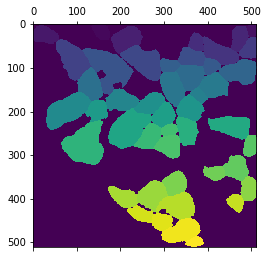

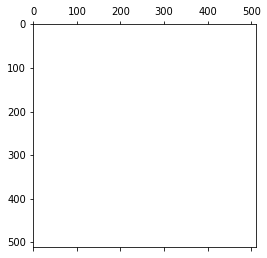

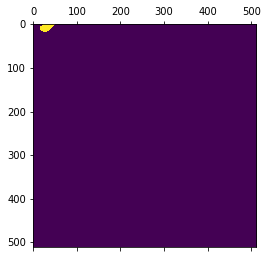

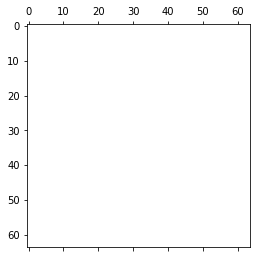

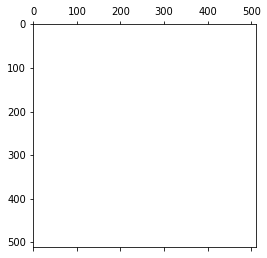

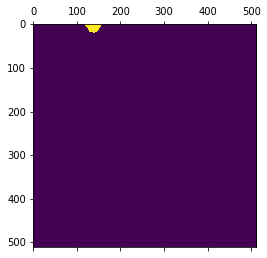

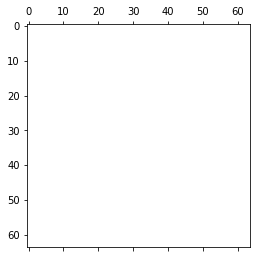

In [16]:
crop_imgs, crop_masks = mask_to_patch(mask_trans, test_path, mask_path, size=64)